## Image Simluation with COSMOS Real galaxy Dataset

In our galaxy deconvolution project, it is crucial that we properly generate a dataset comprised of blurred galaxy images (input) and non-blurred galaxy images (ground truth) to train and test our model. This notebook will show you the **image simulation** process in our project. We used the python package [Galsim](https://github.com/GalSim-developers/GalSim) and the [COSMOS Real Galaxy Dataset](https://zenodo.org/record/3242143#.Ytjzki-KFAY). 

Our forward model is desciribed by the following equation, where the distant galaxy $\mathbf{G}$ is sheared and convolved with the effective point spread function $\mathbf{PSF}$ and added by noises $\mathbf{N}$ to get the observed galaxy $\mathbf{O}$.

$\begin{equation} \mathbf{O} = shear(\mathbf{G}) \otimes \mathbf{PSF} + \mathbf{N} \end{equation}$

To simulate a typical **ground-based** sky survey, we used the parameters for [**LSST**](https://www.lsst.org).

In [15]:
# %pip install Galsim

import os
import numpy as np
import matplotlib.pyplot as plt
import galsim

%matplotlib inline

### Read out galaxy from real galaxy catalog

Download the [COSMOS Real Galaxy Dataset](https://zenodo.org/record/3242143#.Ytjzki-KFAY). Initialize the RealGalaxyCatalog and read out galaxy with an index. Take a look at the original images and you'll notice it has a higher resolution. This is because the HST has a pixel scale of 0.5 arcsec.

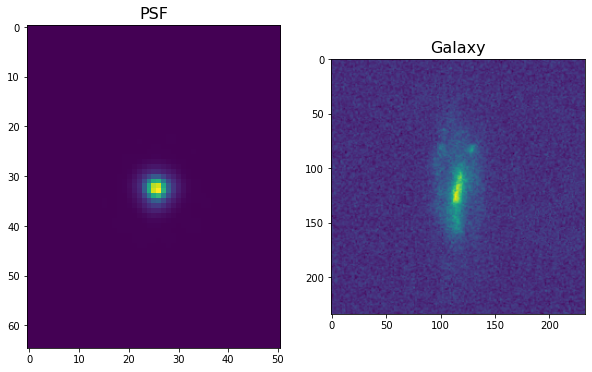

In [16]:
# Initialize catalog
cosmos_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/' # path to your COSMOS data
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=cosmos_dir, sample="23.5")

# Pick a galaxy
i = 0 # randomly select a galaxy
gal_ori_image = real_galaxy_catalog.getGalImage(i)
psf_ori_image = real_galaxy_catalog.getPSFImage(i)

# Visulaize galaxy & PSF in COSMOS data
plt.figure(i,figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(psf_ori_image.array)
plt.title('PSF', fontsize=16)
plt.subplot(1,2,2)
plt.imshow(gal_ori_image.array) 
plt.title('Galaxy', fontsize=16)
plt.show()

### Simulate Point Spread Function

**Point Spread Functions (PSF)** is the most crucial component in our image simulation. In our image formation model, we assume the PSF consists of two components caused by the atmospheric turbulence and the optical structure of the telescope respectively to approximate a typical ground-based obseravtion, i.e. the overall PSF is the convolution of the two components:
$\begin{equation} PSF = PSF_{atmos} \otimes PSF_{opticl} \end{equation}$

To add randomness in our simulation, we use the random number generator provided by Galsim. Here we initialize it with a random seed.


In [17]:
random_seed = 91374 # randomly choose a seed for the rng
rng = galsim.UniformDeviate(seed=random_seed) # Initialize the random number generator

Set up parameters for the PSF. Most of the parameters are the same as LSST. Here we sampled the seeing form a truncated Gaussian distribution to simulate a realistic observation.

In [18]:
psf_flux = 2.e5

# Atmospheric PSF
seeing = 0.7                        # FWHM of the Kolmogorov function
atmos_max_shear = 0.2
rng_gaussian = galsim.GaussianDeviate(seed=random_seed, mean=seeing, sigma=0.18)
atmos_fwhm = 0                      # arcsec (0.7 for LSST)
while atmos_fwhm < 0.35 or atmos_fwhm > 1.1: # sample fwhm
    atmos_fwhm = rng_gaussian()
atmos_e = rng() * atmos_max_shear   # ellipticity of atmospheric PSF
atmos_beta = 2. * np.pi * rng()     # radians
atmos_g1 = atmos_e * np.cos(atmos_beta)
atmos_g2 = atmos_e * np.sin(atmos_beta)

# Optical PSF
opt_defocus = 0.3 + 0.4 * rng()     # wavelengths
opt_a1 = 2*0.5*(rng() - 0.5)        # wavelengths (-0.29)
opt_a2 = 2*0.5*(rng() - 0.5)        # wavelengths (0.12)
opt_c1 = 2*1.*(rng() - 0.5)         # wavelengths (0.64)
opt_c2 = 2*1.*(rng() - 0.5)         # wavelengths (-0.33)
opt_obscuration = 0.165             # linear scale size of secondary mirror obscuration $(3.4/8.36)^2$
lam = 700                           # nm
tel_diam = 8.36                     # telescope diameter / meters (8.36 for LSST)

Now we can simulate the two PSF components respectively and convolve them together. We used the Kolmogorov function to simulate the atmospheric PSF while the optical component is an aberrated PSF caused by telescope optics. The flux for the PSFs are all 1.

In [19]:
# Atmospheric component
atmos = galsim.Kolmogorov(fwhm=atmos_fwhm, flux=1) # Note: the flux here is the default flux=1.
atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)

# Optical component
lam_over_diam = lam * 1.e-9 / tel_diam # radians
lam_over_diam *= 206265  # arcsec
optics = galsim.OpticalPSF( lam_over_diam,
                        defocus = opt_defocus,
                        coma1 = opt_c1, coma2 = opt_c2,
                        astig1 = opt_a1, astig2 = opt_a2,
                        obscuration = opt_obscuration,
                        flux=1)

# Convolve the two components
psf = galsim.Convolve([atmos, optics], real_space=True)

### Simulate Observed Galaxy

Similarly, we choose appropriate parameters first.

In [20]:
sky_level = 1e3                   # ADU / arcsec^2
gal_flux = 2.5e4                     # arbitrary choice, makes nice (not too) noisy images
gal_max_shear = 0.5                 # maximum ellipticity for the galaxy
gal_e = rng() * gal_max_shear       # shear of galaxy
gal_beta = 2. * np.pi * rng()       # radians
gal_g1 = gal_e * np.cos(gal_beta)
gal_g2 = gal_e * np.sin(gal_beta)
gal_mu = 1 + rng() * 0.1            # mu = ((1-kappa)^2 - g1^2 - g2^2)^-1 (1.082)
theta = 2. * np.pi * rng()          # radians

Then we initialize a RealGalaxy object with the real galaxy we chose in the COSMOS real galaxy catalog.

In [21]:
gal_ori = galsim.RealGalaxy(real_galaxy_catalog, index = i, flux = gal_flux)
psf_ori = real_galaxy_catalog.getPSF(i)
gal_ori = galsim.Convolve([psf_ori, gal_ori]) # concolve wth original PSF of HST

Now we randomly rotate, shear and magnify the galaxy to simulated a real galaxy twisted by weak lensing effects. Finally we convolve the galaxy PSF to obtain a galaxy image that reaches the detector real obseravtion.

In [22]:
gal = gal_ori.rotate(theta * galsim.radians) # Rotate by a random angle
gal = gal.shear(e=gal_e, beta=gal_beta * galsim.radians) # Apply the desired shear
gal = gal.magnify(gal_mu) # Also apply a magnification mu = ((1-kappa)^2 - |gamma|^2)^-1, this conserves surface brightness, so it scales both the area and flux.

gal_final = galsim.Convolve([psf, gal]) # Make the combined profile

### Draw and Plot Images

The last step is to draw the images and add noises. We choose the following parameters to simulate a typical ground-based observation.

In [23]:
img_size = (48,48)
pixel_scale = 0.2 # (aresec) determines the resolution, 0.2 for LSST

# CCD parameters
read_noise = 9. # read noise (e-), 9 for LSST
gain = 0.34 # gain (e-/ADU), 0.34 for LSST

# Offset by up to 1/2 pixel in each direction
dx = rng() - 0.5
dy = rng() - 0.5

Now we draw the images of observed galaxy, original galaxy and PSF. To simulate a real observation, we add CCD noise to PSF and observed images.

In [24]:
# Draw observed galaxy
obs = galsim.ImageF(img_size[0], img_size[1])
gal_final.drawImage(obs, scale=pixel_scale, offset=(dx,dy), method='auto')
obs += sky_level * (pixel_scale**2) # Add a constant background level
obs.addNoise(galsim.CCDNoise(rng, gain=gain, read_noise=read_noise)) # add noise for observation

# Draw ground turth
gal_image = galsim.ImageF(img_size[0], img_size[1])
gal.drawImage(gal_image, scale=pixel_scale, offset=(dx,dy), method='auto')
gal_image += sky_level * (pixel_scale**2)

# Draw PSF
psf_image = galsim.ImageF(img_size[0]-1, img_size[1]-1)
psf.drawImage(psf_image, scale=pixel_scale, offset=(dx,dy), method='auto')
psf_image = psf_image*psf_flux + sky_level * (pixel_scale**2) # Add a constant background level
psf_image.addNoise(galsim.CCDNoise(rng, gain=gain, read_noise=read_noise)) # add noise for observation

Finally we can visualize our simulated galaxy.

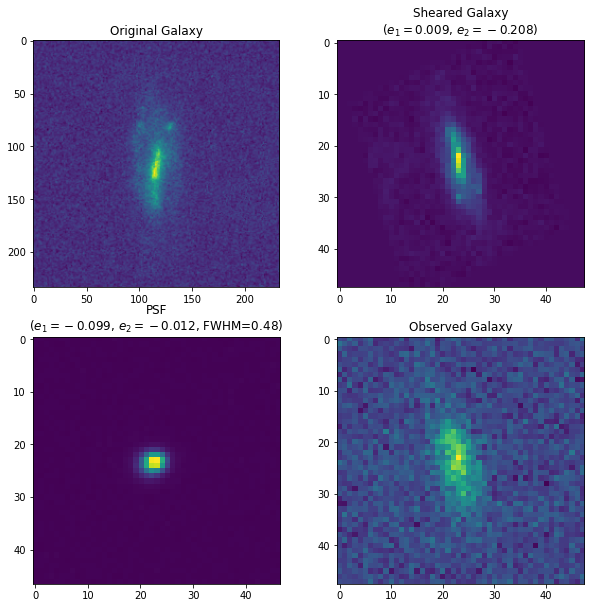

In [25]:
# Visualization
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(gal_ori_image.array)
plt.title('Original Galaxy')
plt.subplot(2,2,2)
plt.imshow(gal_image.array)
plt.title('Sheared Galaxy\n($e_1={:.3f}$, $e_2={:.3f}$)'.format(gal_g1, gal_g2))
plt.subplot(2,2,3)
plt.imshow(psf_image.array)
plt.title('PSF\n($e_1={:.3f}$, $e_2={:.3f}$, FWHM={:.2f})'.format(atmos_g1, atmos_g2, atmos_fwhm))
plt.subplot(2,2,4)
plt.imshow(obs.array)
plt.title('Observed Galaxy')
plt.show()

In [26]:
print(psf_image.array.min(), psf_image.array.max(), psf_image.array.mean())
print(gal_image.array.min(), gal_image.array.max(), gal_image.array.mean())
print(obs.array.min(), obs.array.max(), obs.array.mean())

-59.99642 14099.052 130.71713
15.878786 709.0382 51.90163
-57.673557 399.44534 52.60004
